# Introduction to Topic Modelling For Business

---



#### The following code and tutorial is modified from the Coursera course from Barsha Saha. This particular notebook is my attempt at trying to do Topic Modeling for a new use case. I am using Kaggle's Book Depository Datset. 
---


#### Topic model is a statistical model to find latent "topics" or themes from a collection of documents (corpus).
#### It is a frequently used text-mining tool to extract hidden semantic structures in a corpus.
#### These structures could be considered as cluster words for a set of documents. This method is a type of 'unsupervised' machine learning as it does not require any predefined list of tags or training data for analysis.

#### Advantages:
    -The document-generative process can be adapted to other kinds of analyses, keeping only the analogy between document-topic-word and other kinds of objects. Therefore, the basis of topic modeling is the appointment of three objects: documents, words, and topics.
    -Manually doing the same is cumbersome and inefficient

#### Usage:

    Businesses can use Topic Modelling methods to decipher themes from annual reports, news covers, social media posts, related articles, latest trends in the domain, etc.

For the Coursera-based project we will use the:

### Book Depository Dataset (from Kaggle) 

This dataset contains books from bookdepository.com, not the actual content of the book but a list of metadata like title, description, dimensions, category and others. I used the Dataset.csv and the topic models will be built off of the summary data. Please find the link to the dataset [here](https://www.kaggle.com/sp1thas/book-depository-dataset).
   
This project is divided in 6 tasks:

####Task 1: Introduction to the dataset
####Task 2: Data cleaning and preparation
####Task 3: Exploratory analysis with WordCloud
####Task 4: Prepare data for Topic Modelling
####Task 5: Build Topic Model
####Task 6: Visualize Model

##### For the task below, we are utilizing Gensim. Further information about Gensim can be found at the following links [here](https://radimrehurek.com/gensim/models/ldamulticore.html) and [here](https://radimrehurek.com/gensim/models/ldamodel.html). These tools can be utilized in Python to conduct NLP and are optimized for efficiency (e.g. parallelism with CPU Cores). 

###Task 1: Introduction to the dataset

Importing Modules

In [1]:
# Importing modules
import pandas as pd
import os
os.chdir('..')

import numpy as np
import re, nltk, spacy, gensim

import logging
import warnings
warnings.filterwarnings('ignore')  

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

In [3]:
# Upload .csv file
## This may take some time... 
from google.colab import files 
uploaded = files.upload()

Saving BookDataset.csv to BookDataset.csv


In [5]:
# Store dataset in a Pandas Dataframe
import io 
df = pd.read_csv(io.BytesIO(uploaded['BookDataset.csv']))

Read dataset

A few insights here. When we run df.head(), we get an overview of what the data looks like. From this, it appears that the description tag is what we likely care about because it contains a description of the books.

In [6]:
df.head()

,authors,bestsellers-rank,categories,description,dimension-x,dimension-y,dimension-z,edition,edition-statement,for-ages,format,id,illustrations-note,imprint,index-date,isbn10,isbn13,lang,publication-date,publication-place,rating-avg,rating-count,title,url,weight
0,[1],NaN,"[334, 335, 341, 2622, 352, 2626, 353, 2627]",Renowned urban artist Shepard Fairey's new loo...,111.0,181.0,20.0,NaN,Repr.,NaN,1,9780141036144,NaN,NaN,2020-05-31 12:59:51,141036141,9.780141e+12,en,2008-10-01,1.0,4.18,2918204.0,1984,/1984-George-Orwell/9780141036144,184.00
1,[2],67532,"[376, 378, 868, 873, 900, 2771, 3097, 2590]","These 100 skills, adapted for civilians from a...",140.0,210.0,18.0,NaN,NaN,NaN,1,9781501143908,b&w illustrations t-o; rounded edges,NaN,2020-05-31 13:00:12,1501143905,9.781501e+12,en,2016-11-16,2.0,4.01,425.0,100 Deadly Skills: Survival Edition : The SEAL...,/100-Deadly-Skills-Survival-Edition-Clint-Emer...,367.00
2,"[3, 4]",150327,"[2978, 2980]",The world is full of pointless things. From ra...,193.0,197.0,21.0,NaN,NaN,NaN,1,9781444762051,integrated black and white,Coronet Books,2020-05-31 13:00:34,1444762052,9.781445e+12,en,2013-05-23,1.0,3.59,539.0,The 100 Most Pointless Things in the World : A...,/100-Most-Pointless-Things-World-Alexander-Arm...,220.00
3,[5],85902,"[2948, 2953]",Delight children and adults alike by creating ...,148.0,210.0,12.7,NaN,NaN,NaN,1,9781784943462,"20 illustrations, 160 photographs in full colour",STERLING,2020-05-31 13:00:55,1784943460,9.781785e+12,en,2017-11-14,2.0,3.66,9.0,50 Knitted Dolls,/50-Knitted-Dolls-Sarah-Keen/9781784943462,771.11
4,[6],54186,"[2942, 2948, 2953]",Make your own collection of irresistibly cute ...,155.0,215.0,4.0,NaN,NaN,NaN,1,9781782216957,"100 Illustrations, color",NaN,2020-05-31 13:01:36,1782216952,9.781782e+12,en,2019-06-04,3.0,4.66,6.0,20 to Knit: Pocket Pets,/20-Knit-Pocket-Pets-Sachiyo-Ishii/9781782216957,130.00


In [7]:
print(df.shape)
## These results (56009, 25) should make sense because we have 56009 books that have been analyzed and 25 columns for each book. 

(56009, 25)


### Task 2: Data cleaning and preparation

**The Model** will be built on the column 'Abstract'.
Other columns could be used for exploratory analysis, but for this case, we only need abstract. 

In [8]:
df['description'].head()
## Something to note is that .head() defaults to n = 5 and basically yields the first 5 rows depending on its input. 
## In this case, we specify we want the abstracts of the first five rows! 

0    Renowned urban artist Shepard Fairey's new loo...
1    These 100 skills, adapted for civilians from a...
2    The world is full of pointless things. From ra...
3    Delight children and adults alike by creating ...
4    Make your own collection of irresistibly cute ...
Name: description, dtype: object

In [21]:
## Scrubbing no abstract available from dataset
## df.drop removes stuff. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html. DF stands for dataframe.

nan_value = float("NaN") # checks for not a number
df.replace("", nan_value, inplace=True) #  not a number or blank spaces. 
df.dropna(subset = ["description"], inplace=True) # super useful python call to drop missing values! 

# In the original dataset, row 20 had a blank item. By checking this, I can see if what I did above actually worked! 
print(df['description'].head(20))

0     Renowned urban artist Shepard Fairey's new loo...
1     These 100 skills, adapted for civilians from a...
2     The world is full of pointless things. From ra...
3     Delight children and adults alike by creating ...
4     Make your own collection of irresistibly cute ...
5     Thirteen plays by the Oscar-winning author of ...
6                    The 9/11 Report for Every American
7     Adam Zamoyski's bestselling account of Napoleo...
8     The Nazi siege of Leningrad from 1941 to 1944 ...
9     Detailed instructions for creating standard tw...
10    As a good drawing is often better than a thous...
11    Looking for a great piece to work on in your s...
12    This is the evocative history of the 5th Marin...
13    With a flood of research showing the dangers o...
14    This special re-print edition of H. Cecil Shep...
15    From Massachusetts to Florida to Washington to...
16    New edition of annually revised, politically c...
17    The Marquis de Sade, vilified by respectab

In [23]:
print(df.shape)
# Note the drop in number of rows. This is because we've removed the no description available sections! 

(51987, 25)


In [25]:
## This is the regular expression library! 
## https://docs.python.org/3/library/re.html

## Here, this library is utilized to clean up data via removing punctuation and lowercasing all the data. 
import re

# Remove punctuation, p_abstract means processed abstracts. 
df['p_description'] = df['description'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df['p_description'] = df['p_description'].map(lambda x: x.lower())

# Print out the first rows of papers
df['p_description'].head(20)

0     renowned urban artist shepard fairey's new loo...
1     these 100 skills adapted for civilians from ac...
2     the world is full of pointless things from rai...
3     delight children and adults alike by creating ...
4     make your own collection of irresistibly cute ...
5     thirteen plays by the oscar-winning author of ...
6                    the 9/11 report for every american
7     adam zamoyski's bestselling account of napoleo...
8     the nazi siege of leningrad from 1941 to 1944 ...
9     detailed instructions for creating standard tw...
10    as a good drawing is often better than a thous...
11    looking for a great piece to work on in your s...
12    this is the evocative history of the 5th marin...
13    with a flood of research showing the dangers o...
14    this special re-print edition of h cecil shepp...
15    from massachusetts to florida to washington to...
16    new edition of annually revised politically co...
17    the marquis de sade vilified by respectabl

### Task 3: Exploratory Analysis with WordCloud

Build wordclouds for Title and Abstract fields.

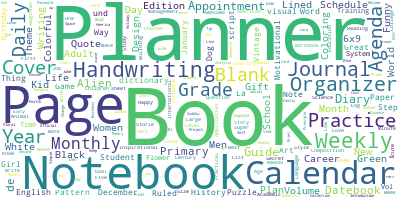

In [27]:
#For Title

# Import the wordcloud library
from wordcloud import WordCloud

# Join the different titles together.
# This quite literally joins all the different titles together into a giant string with a comma to seperate them. 

# Ironically, the new dataset also has a title section (called title not Title), so we just use that here. 
long_string = ','.join(list(df['title'].values))

# Generate the word cloud
wordcloud = WordCloud(background_color="white", 
                      max_words=500, 
                      contour_width = 3, 
                      contour_color = 'steelblue', 
                      collocations = False).generate(long_string)

# Generate the word cloud but with only 200 words now! 
# wordcloud2 = WordCloud(background_color="white", 
#                       max_words=200, 
#                       contour_width = 3, 
#                       contour_color = 'steelblue', 
#                       collocations = False).generate(long_string)

# Visualize the word cloud
wordcloud.to_image()


Now, we should remove the commonly used words (or irrelevant according to the context) from the wordcloud. 

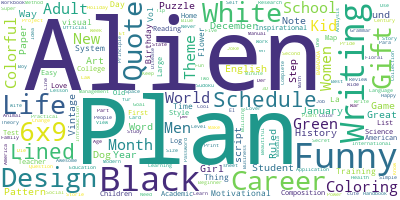

In [35]:
## Remove STOPWORDS taking reference from previous wordcloud
## In computing, stop words are words which are filtered out before or after processing of natural language data. 

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Create stopword list:
stopwords = set(STOPWORDS)

# In our case, because we are dealing with books and book descriptions, some stop words may be related to books/notebooks/planners 
# simply because that doesn't tell us anything about the context of the books themselves. 

# The below is an example; this can be modified as needed. 

stopwords.update(["notebook", "calendar", "page", "journal", "organizer", "book", "planner", "agenda", 
                 "diary", "datebook", "cover", "year", "blank", "dictionary", "edition", "books",
                  "daily", "handwriting", "planners", "calendars", "organizers", "grade", "practice", 
                 "pages", "weekly", "monthly", "appointment", "grades", "primary", "guide", "datebooks",
                  "day","agendas","volume", "de"])

# Generate the word cloud
wordcloud3 = WordCloud(stopwords=stopwords, 
                       background_color="white", 
                      max_words=200, 
                      contour_width = 3, 
                      contour_color = 'steelblue', 
                      collocations = False).generate(long_string)

# It's interesting that Alien is so prevalent in the data?
# Something to note is that not all the titles are in English! Maybe that impacts the data?

# Visualize the word cloud
wordcloud3.to_image()

###Task 4: Prepare data for Topic Modelling

Step 1: Split sentences to words

In [37]:
%%time
import gensim
from gensim.utils import simple_preprocess

# Simple pre-processs converts a document into a list of tokens.
# This lowercases, tokenizes, de-accents (optional). – the output are final tokens = unicode strings, that won’t be processed any further.
# Tokenization is a way of separating a piece of text into smaller units called tokens. Here, tokens can be either words, characters, or subwords. 
# Hence, tokenization can be broadly classified into 3 types – word, character, and subword (n-gram characters) tokenization.

def sent_to_words (sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = df.p_description.values.tolist() # tolist() function return a list of the values. So this is just a list of the description for the words. 
data_words = list(sent_to_words(data)) 
print(data_words[:1]) # an example of the output is printed. 


[['renowned', 'urban', 'artist', 'shepard', 'fairey', 'new', 'look', 'for', 'orwell', 'dystopian', 'masterpiece']]
CPU times: user 10.1 s, sys: 304 ms, total: 10.4 s
Wall time: 10.4 s


Step 2: Build N-grams


> Bigrams: Bigram is 2 consecutive words in a sentence. E.g. “The boy is playing football”. The bigrams here are: The boy Boy is Is playing Playing football. 

> Trigrams: Trigram is 3 consecutive words in a sentence. For the above example trigrams will be: The boy is Boy is playing Is playing football.





---



In [38]:
#N Grams is a sequence of n-words that are commonly occuring together. 

# Build the bigram and trigram models
# Automatically detect common phrases – aka multi-word expressions, word n-gram collocations – from a stream of sentences.

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)          # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words],threshold=100)
# Faster way to get a sentence formatted as a bigram or trigram
bigram_mod = gensim.models.phrases.Phraser (bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)



Step 3: Remove Stopwords

In [39]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english') # commonly occuring stopwords in English 

# We add our own stopwords here! 
stop_words.extend(["notebook", "calendar", "page", "journal", "organizer", "book", "planner", "agenda", 
                 "diary", "datebook", "cover", "year", "blank", "dictionary", "edition", "books",
                  "daily", "handwriting", "planners", "calendars", "organizers", "grade", "practice", 
                 "pages", "weekly", "monthly", "appointment", "grades", "primary", "guide", "datebooks",
                  "day","agendas","volume", "de"])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Lemmatisation in linguistics is the process of grouping together the inflected forms of a word
# so they can be analysed as a single item, identified by the word's lemma, or dictionary form. 

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts: 
      doc = nlp(" ".join(sent)) # This is what's called a doc object. 
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags]) # This basically filters the document for lemma if it's noun, adj, verb, or adv. 
    return texts_out
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Step 4: Lemmatize

In [40]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words) 
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])
# Lemmatize keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1]) # How cool! It picked up the main points of this text. 

[['renowned', 'urban', 'artist']]


Step 5: Build Corpora

In [41]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized) # Dictionary encapsulates the mapping between normalized words and their integer ids.
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
# Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples. 
# Each word is assumed to be a tokenized and normalized string (either unicode or utf8-encoded). 
# No further preprocessing is done on the words in document; apply tokenization, stemming etc. before calling this method.
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

# But what does this output mean?
# The first area of the tuple refers to the word's ID, which is the unique one-hot encoding of that word. 
# The second area of the tuple refers to the number of times that word shows up in the text. 

[[(0, 1), (1, 1), (2, 1)]]


###Task 5: Build topic model

In [43]:
# Build LDA model

# In natural language processing, the latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained
# by unobserved groups that explain why some parts of the data are similar.
# https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=id2word,
                                            num_topics = 10, 
                                            random_state = 123, 
                                            chunksize=100, 
                                            passes = 10, 
                                            alpha = 0.01, 
                                            eta = 'auto', 
                                            iterations = 400, 
                                            per_word_topics = True
                                            )

In [45]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.078*"gift" + 0.029*"last" + 0.028*"fan" + 0.024*"name" + 0.023*"fur" + '
  '0.023*"line" + 0.022*"late" + 0.019*"white" + 0.019*"hold" + '
  '0.017*"weight"'),
 (1,
  '0.050*"maybe" + 0.029*"help" + 0.026*"use" + 0.019*"potential" + '
  '0.018*"skill" + 0.017*"eventually" + 0.017*"way" + 0.017*"must" + '
  '0.016*"virtue" + 0.016*"find"'),
 (2,
  '0.020*"feature" + 0.019*"include" + 0.016*"design" + 0.011*"call" + '
  '0.010*"present" + 0.010*"week" + 0.010*"reader" + 0.009*"write" + '
  '0.009*"new" + 0.009*"also"'),
 (3,
  '0.026*"information" + 0.015*"provide" + 0.013*"include" + 0.012*"key" + '
  '0.010*"study" + 0.010*"cover" + 0.010*"reference" + 0.009*"fill" + '
  '0.009*"protein" + 0.009*"important"'),
 (4,
  '0.056*"work" + 0.053*"imperfection" + 0.042*"true" + 0.041*"flaw" + '
  '0.041*"marginalia" + 0.038*"world" + 0.034*"die" + 0.034*"make" + '
  '0.033*"believe" + 0.031*"sport"'),
 (5,
  '0.102*"work" + 0.039*"know" + 0.037*"part" + 0.028*"original" + 0.024*"see"

In [46]:
from gensim.models import CoherenceModel

# Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. 
# These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference. 

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus) )  # A measure of how good the model is. Lower value is preferred.

# Compute Coherence Score
# This relates to the score based on a sliding window, one-set segmentation of the top words and indirect confirmation measure that uses NPMI and cosine similarity. 
coherence_model_lda = CoherenceModel  (model=lda_model, texts=data_lemmatized, dictionary = id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda )

# Compute Coherence Score using UMass
# This is is based on document cooccurenace, a one-preceding segmentation, and a logrithmic conditional probabilty. 
coherence_model_lda = CoherenceModel (model= lda_model, texts=data_lemmatized, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence() 
print('\nCoherence Score u_mass: ', coherence_lda )


Perplexity:  -121.84025508888766

Coherence Score:  0.5369960677936556

Coherence Score u_mass:  -3.2527927429634778


###Task 6: Visualize model

In [47]:
# Visualize the topics
# Python library for interactive topic model visualization. pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data.
!pip install -U pyLDAvis
import pyLDAvis.gensim


     |████████████████████████████████| 1.6MB 2.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=ed26a9b58e7dcd0cd9bc60c1a011f9cf33faf05586c62e2fba4f1f6d6c969c64
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


The distance between text is an indicator of how semantically different the topics are; the farther apart, the better and unique the topics are. 

In [48]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model,corpus,id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.175160  0.027606       1        1  19.368752
8      0.127204  0.080909       2        1  19.004809
3      0.079365 -0.046546       3        1  11.583865
7      0.114383  0.146678       4        1  10.928630
9      0.076532  0.109697       5        1   8.365638
4     -0.345539  0.102937       6        1   8.169561
1      0.102019  0.085491       7        1   7.463077
5     -0.326654  0.074429       8        1   6.420133
6      0.065482 -0.186910       9        1   4.919802
0     -0.067951 -0.394291      10        1   3.775733, topic_info=              Term          Freq         Total Category  logprob  loglift
88            work  19069.000000  19069.000000  Default  30.0000  30.0000
80            make  15529.000000  15529.000000  Default  29.0000  29.0000
1377  imperfection   7124.000000   7124.000000  Default  28.0000  28.0000
765          maybe   6175.000000   6175.000000  Default  27.0000  27.0000
72            gift   4839.000000   4839.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
8478        empire    309.650529    309.818655  Topic10  -5.3030   3.2760
650           grow    939.220438   1177.279942  Topic10  -4.1934   3.0507
674           line   1427.367411   2288.691926  Topic10  -3.7748   2.8044
1343        decade    550.243980   1191.885020  Topic10  -4.7280   2.5036
2372         train    419.956007   1569.731695  Topic10  -4.9983   1.9581

[468 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
939       6  0.999713    account
1224      3  1.000231     action
698       3  1.000006    address
3343      3  0.999890    advance
1595      4  1.000237  adventure
...     ...       ...        ...
401       6  1.000054      would
50        1  0.671210      write
50        9  0.328738      write
166       1  0.344440       year
166       5  0.655477       year

[578 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 4, 8, 10, 5, 2, 6, 7, 1])

References

Liu, L., Tang, L., Dong, W., Yao, S., & Zhou, W. (2016). An overview of topic modeling and its current applications in bioinformatics. SpringerPlus, 5(1), 1608. https://doi.org/10.1186/s40064-016-3252-8)

Coursera. “Introduction to Topic Modeling for Business - Home.” Accessed October 14, 2020. https://www.coursera.org/learn/introduction-to-topic-modeling-for-business/home/welcome.